In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import os
from scipy.stats import qmc
from sklearn.metrics import precision_score,recall_score
from torch.optim.lr_scheduler import MultiStepLR

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
torch.cuda.is_available()
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(device)

cpu


# Functions

In [4]:
def accuracy_fn(pred_labels, gt_labels):
    return (torch.mean((pred_labels == gt_labels).float()) * 100).item()

In [17]:
def ber_max_call_mult(paths,times,R=10,i=1,T=3,N=9, K=100, r = 0.05):
    ### Takes [M,R,D,N+1-i]-dimensional tensor of R paths OR a [M,D]-dimensional tensor of prices;
    ### [M,R,]-dimensional tensor of times OR float with single time
    ### and returns a [M,R,1]-dimensional tensor with prices OR M tensor of prices
    if R == 1:
        payoff = torch.relu(torch.amax(paths,dim=-1) - K)
        discounted_payoff = np.exp(-r*times*T/N)*payoff
        return(discounted_payoff)
    M, R, D,_ = paths.shape
    payoff = torch.relu(torch.amax(paths, dim=2) - K)

    indices = (times - i).unsqueeze(-1)
    # Select the appropriate path slices
    payoff_slices = torch.gather(payoff, 2, indices).squeeze(2)
    # Calculate discounted payoff
    discounted_payoff = torch.exp(-r * times * T / N) * payoff_slices
    return discounted_payoff

**sim_bach:**
$$
dX_t = (r-\delta)\, X_t\,dt +\sigma\,dB_t
$$
**sim_geom:**
$$
dX_t = (r-\delta)\, X_t\,dt + \sigma\,X_t\,dB_t
$$


In [6]:
def sim_geom_mult(prices=torch.tensor([90,90]).to(device), R=10, i=1, T=3, N=9, r=0.05, delta=0.1, vol=0.2):
    ### Takes [M,D]-dimensional tensor of M starting prices OR a D-dimensional
    ### tensor with a single starting price;
    ### Returns a [M,R,D,N-i+1]-dimensional or [R,D,N-i+1]-dimensional tensor
    ### with R paths starting at prices.
    dt=T/N
    if len(prices.shape) == 2:
        M, D = prices.shape
        dB = torch.normal(0, torch.sqrt(torch.tensor(dt)), (M,R,D,N-i))
        path = torch.exp((r-delta-(vol**2)/2)*dt +vol *dB)
        path = torch.cat((torch.ones([M,R,D,1]),path),dim = -1).to(device)
        prices = prices.unsqueeze(1).expand(M, R, D).unsqueeze(-1)

    elif len(prices.shape) == 1:
        D = prices.shape[0]
        dB = torch.normal(0, torch.sqrt(torch.tensor(dt)), (R,D,N-i))
        path = torch.exp((r-delta-(vol**2)/2)*dt +vol *dB)
        path = torch.cat((torch.ones([R,D,1]),path),dim = -1).to(device)
        prices = (prices.expand(R,D)).unsqueeze_(-1)
    else:
        raise ValueError("Prices tensor must be of shape D or M,D.")
    path = prices * path.cumprod_(dim=-1)
    return path

def sim_bach_mult(prices=torch.tensor([90,90]).to(device), R=10, i=1, T=3, N=9, r=0.05, delta=0.1, vol=0.2):
    ### Takes [M,D]-dimensional tensor of M starting prices OR a D-dimensional
    ### tensor with a single starting price;
    ### Returns a [M,R,D,N-i+1]-dimensional or [R,D,N-i+1]-dimensional tensor
    ### with R paths starting at prices.
    dt=T/N
    if len(prices.shape) == 2:
        M, D = prices.shape
        dB = torch.normal(0, torch.sqrt(torch.tensor(dt)), (M,R,D,N-i)).to(device)
        increments = (r - delta) * dt + vol * dB
        prices = prices.unsqueeze(1).expand(M, R, D).unsqueeze(-1)
        increments = torch.cat((prices,increments),dim = -1)

    elif len(prices.shape) == 1:
        D = prices.shape[0]
        dB = torch.normal(0, torch.sqrt(torch.tensor(dt)), (R,D,N-i)).to(device)
        increments = (r - delta) * dt + vol * dB
        prices = (prices.expand(R,D)).unsqueeze_(-1)
        increments = torch.cat((prices,increments),dim = -1)
    else:
        raise ValueError("Prices tensor must be of shape D or M,D.")
    path = increments.cumsum_(dim=-1)
    return path

In [7]:
def gen_grid(M=32,a=50,b=150):
    #Returns MxM evenly spaced grid in an (M,2) vector
    x_values = torch.linspace(a, b, M)
    y_values = torch.linspace(a, b, M)
    grid = torch.meshgrid(x_values, y_values)
    grid = torch.stack(grid, dim=-1).view(-1, 2)
    return grid


def cont_value_mult(pricing,stopping_times, paths, T=3, N=9, K=100, r=0.05):
    i = N + 1 - paths.size(dim=-1)
    R = paths.size(dim=1)
    path_values = pricing(paths, stopping_times,R,i,T, N, K, r)
    continuation_value = path_values.mean(dim=1)
    return continuation_value


def initial_value_mult(test_size, replications, x_0, T, N, K, r, classifiers,
                  underlying_sim, pricing):
    for fn in classifiers:
        fn.eval()
    x_0 = x_0.unsqueeze(0).expand(replications, -1)
    G_0 = pricing(x_0,0,1,0,T,N,K,r)

    test_paths = underlying_sim(x_0,test_size, 0, T, N, r, delta, vol).to(device)

    reshaped_paths = test_paths.view(test_size*replications, D, N+1)
    actions = torch.stack(
        [fn(reshaped_paths[:, :, k+1]) for k, fn in enumerate(classifiers[1:])], dim=1
    ).view(replications,test_size, -1)
    best_action = (actions > 0.5).int()

    ## Compute the first time in which stopping is optimal
    test_stop_times = torch.flatten( 1 + torch.argmax(best_action, dim=-1), start_dim=1)

    C_v_0 = cont_value_mult(pricing, test_stop_times, test_paths,T, N,K,r)
    value = torch.max(C_v_0, G_0)
    mu_0 = value.mean()
    std_0 = value.std()
    print(f"Initial Value:{mu_0:.3f}. Standard deviation: {std_0:.3f}")
    return(mu_0)

# NN Classes

In [8]:
class Classifier(nn.Module):
    def __init__(self,D):
        super(Classifier, self).__init__()
        self.lin1 = nn.Linear(D, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.lin2 = nn.Linear(256, 128)
        self.lin3 = nn.Linear(128, 64)
        self.lin4 = nn.Linear(64, 1)

        torch.nn.init.kaiming_uniform_(self.lin1.weight,nonlinearity='relu')
        torch.nn.init.kaiming_uniform_(self.lin2.weight,nonlinearity='relu')
        torch.nn.init.kaiming_uniform_(self.lin3.weight,nonlinearity='relu')
        torch.nn.init.xavier_uniform_(self.lin4.weight)

        scale = 0.1
        self.lin1.weight.data *= scale
        self.lin2.weight.data *= scale
        self.lin3.weight.data *= scale

    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = torch.nn.functional.relu(x)
        x = self.lin2(x)
        x = torch.nn.functional.relu(x)
        x = self.lin3(x)
        x = torch.nn.functional.relu(x)
        x = self.lin4(x)
        return torch.sigmoid(x)


class Constant_model(nn.Module):

    def __init__(self,dev):
        super(Constant_model, self).__init__()
        self.device = dev
    def forward(self, x):
        if x.dim() == 1:
            # If input is a 1D tensor, return a 1D tensor of ones
            return torch.ones(1).to(self.device)
        return torch.ones([x.size(0),1]).to(self.device)


# Main code

In [9]:
def train_classifiers(R, T, N, K, r, delta, vol, learning_rate, D, M, num_epochs,
                      nn_batch_size, patience, classifiers, underlying_sim, pricing):
    sampler = qmc.LatinHypercube(d=D)
    u_bound = [180]*D
    l_bound = [30]*D

    for i in range(N-1,0, -1):
        sample = sampler.random(n=M*D)
        x_train = torch.tensor(qmc.scale(sample, l_bound, u_bound),dtype=torch.float).to(device)

        paths = underlying_sim(x_train,R, i, T, N, r, delta, vol).to(device)

        ## Compute for all paths the action of all classifiers[i+1:]
        reshaped_paths = paths.view(M * R * D, D, N-i+1)
        actions = torch.stack(
            [fn(reshaped_paths[:, :, k+1]) for k, fn in enumerate(classifiers[i+1:])], dim=1
        ).view(M * D, R, -1)
        best_action = (actions > 0.5).int()

        ## Compute the first time in which stopping is optimal
        stop_times = torch.flatten(i + 1 + torch.argmax(best_action, dim=-1), start_dim=1)

        C_v = cont_value_mult(pricing,stop_times, paths,T, N,K,r)
        y_train = (pricing(x_train,i,1,i,T,N,K,r)-C_v > 0).int().unsqueeze(1)
        y_train = y_train.type(torch.float)

        stop_prop =100*(y_train.sum(dim=0)/float(M*D)).item()
        print(f"\n Percentage of training samples that stop: {stop_prop:.6f}%" )

        model = classifiers[i]

        ###TRAINING PROCESS###
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=learning_rate/10)
        scheduler = MultiStepLR(optimizer, milestones=[300,800],gamma=0.5)
        dataset = TensorDataset(x_train.float(),y_train)
        split = torch.utils.data.random_split(dataset, [0.8, 0.2])
        train_dataset = split[0]
        training_loader = DataLoader(train_dataset, batch_size=nn_batch_size, shuffle=True)
        val_dataset = split[1]
        validation_loader = DataLoader(val_dataset, batch_size=nn_batch_size, shuffle=False)

        # Fully train the model over the epochs.
        best_val_loss = 1e8
        no_improvement_count = 0

        for ep in range(num_epochs):
            # Train one epoch
            model.train()
            for it, batch in enumerate(training_loader):
                x_train, y_train = batch

                pred_train = model(x_train)

                loss = criterion(pred_train, y_train)

                optimizer.zero_grad()
                loss.backward()

                optimizer.step()

            # Validation step
            model.eval()
            loss_val = 0
            val_preds, val_labels = [], []
            with torch.no_grad():
                for it, batch in enumerate(validation_loader):
                    x_val, y_val = batch

                    pred_val = model(x_val)

                    loss = torch.nn.functional.binary_cross_entropy(pred_val, y_val,reduction='sum' )
                    loss_val += loss

                    val_preds.extend(pred_val.cpu().numpy())
                    val_labels.extend(y_val.cpu().numpy())

            loss_val /= len(val_preds)
            val_preds = (np.array(val_preds) > 0.5).astype(int)
            val_labels = np.array(val_labels).astype(int)

            precision = precision_score(val_labels, val_preds,zero_division= 0.0)
            recall = recall_score(val_labels, val_preds,zero_division= 0.0)

            if loss_val < best_val_loss:
                best_val_loss = loss_val
                best_state =model.state_dict()
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if(ep%100 ==0):
                print(f'Epoch {ep} is done, Loss {loss_val:.5f}, Precision {precision:.5f}, Recall {recall:.5f}')

            if no_improvement_count >= patience:
                print(f'Early stopping after {patience} epochs of no improvement.')
                break
            scheduler.step()
        #Save the best model
        classifiers_dict[f"model_{i}_state_dict"] = best_state
        classifiers[i] = model.eval()
        with torch.no_grad():
            preds_train = (classifiers[i].forward(x_train)>0.5).float()
            acc = accuracy_fn(preds_train, y_train)
            print(f"\n Model {i} has Train set accuracy = {acc:.3f}% ")
            preds_val = (classifiers[i].forward(x_val)>0.5).float()
            acc = accuracy_fn(preds_val, y_val)
            print(f"\n Model {i} has Validation set accuracy = {acc:.3f}% ")
    return classifiers

In [10]:
R = 100
T = 3
N = 9
K = 100
r = 0.05
delta = 0.1
vol = 0.2

learning_rate = 1e-3
D= 2
M = 256
num_epochs = 30
nn_batch_size = int(M*D/4)
patience = 500

In [11]:
# Generate the list of models
classifiers = []
for _ in range(N):
    model = Classifier(D).to(device)
    classifiers.append(model)
maturity = Constant_model(device)
classifiers.append(maturity)

classifiers_dict = {}

In [12]:
PATH = f"drive/MyDrive/TFG/models_piram256_norm_d{D}_dict.pt"

In [19]:
classifiers = train_classifiers(R, T, N, K, r, delta, vol, learning_rate, D, M, num_epochs,
                      nn_batch_size, patience, classifiers, sim_geom_mult, ber_max_call_mult)


 Percentage of training samples that stop: 59.570312%
Epoch 0 is done, Loss 1.12466, Precision 0.95312, Recall 0.96825

 Model 8 has Train set accuracy = 96.154% 

 Model 8 has Validation set accuracy = 90.196% 

 Percentage of training samples that stop: 55.664062%
Epoch 0 is done, Loss 0.42361, Precision 0.83871, Recall 0.92857

 Model 7 has Train set accuracy = 100.000% 

 Model 7 has Validation set accuracy = 86.275% 

 Percentage of training samples that stop: 54.687500%
Epoch 0 is done, Loss 0.28428, Precision 0.94737, Recall 0.96429

 Model 6 has Train set accuracy = 96.154% 

 Model 6 has Validation set accuracy = 93.137% 

 Percentage of training samples that stop: 51.757812%
Epoch 0 is done, Loss 0.35895, Precision 0.92593, Recall 0.89286

 Model 5 has Train set accuracy = 96.154% 

 Model 5 has Validation set accuracy = 91.176% 

 Percentage of training samples that stop: 50.585938%
Epoch 0 is done, Loss 0.29841, Precision 0.89091, Recall 0.96078

 Model 4 has Train set acc

In [ ]:
##SAVE CLASSIFIERS
for i in range(1,N+1):
    classifiers_dict[f"model_{i}_state_dict"] = classifiers[i].state_dict()
torch.save(classifiers_dict, PATH)

In [20]:
##LOAD CLASSIFIERS
checkpoint = torch.load(PATH,map_location=device)
classifiers = []
model = Classifier(D).to(device)
classifiers.append(model)
for i in range(1,N):
    model = Classifier(D).to(device)
    model.load_state_dict(checkpoint[f"model_{i}_state_dict"])
    classifiers.append(model)
maturity = Constant_model(device)
classifiers.append(maturity)

In [18]:
test_size = 16000
replications=10
x_0 = torch.tensor([90]*D).to(device)

In [78]:
## Compute initial value
initial_value_mult(test_size, replications, x_0, T, N, K, r, classifiers, sim_geom_mult, ber_max_call_mult)
torch.cuda.empty_cache()

Initial Value:8.019. Standard deviation: 0.094


# Visualization

<ipython-input-24-6065885aa45e>:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


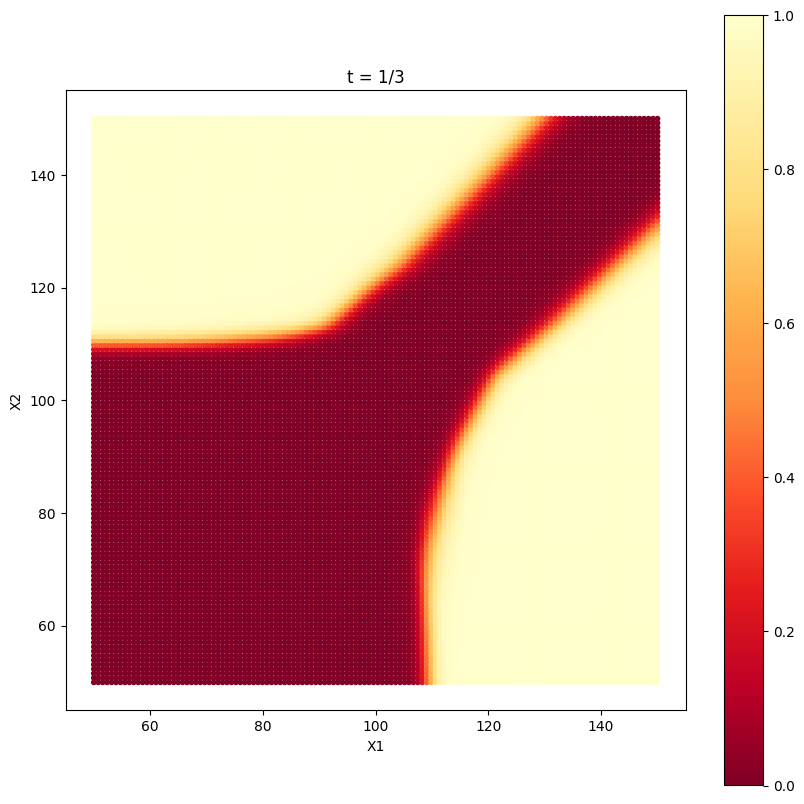

In [24]:
## GENERATE GIF OF ALL OUTPUT SPACES
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
grid = gen_grid(128,50,150)
x_train = grid
# Define color mapping
color_map = "YlOrRd_r"
# Number of frames (N-1 in your case)
N_frames = N - 1

# Create a function to update the plot for each frame
def update(frame):
    plt.clf()  # Clear the previous plot
    i = frame + 1  # Adjust the frame index
    predictor_test = (classifiers[i].cpu().forward(x_train)).detach().numpy()
    plt.scatter(x_train[:, 0], x_train[:, 1], c=predictor_test, cmap=color_map, s=10.0)
    plt.title('t = {}/3'.format(i))
    plt.xlabel('X1')
    plt.ylabel('X2')
    norm = plt.Normalize(predictor_test.min(), predictor_test.max())
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])
    plt.colorbar(sm)
    plt.gca().set_aspect('equal', 'box')
# Create a figure and axes
fig, axs = plt.subplots(1, 1, figsize=(10, 10), dpi=100.0)

# Create the animation
animation = FuncAnimation(fig, update, frames=N_frames, repeat=False)

# Save the animation as a GIF
animation.save('drive/MyDrive/TFG/output_space.gif', writer='pillow', fps=1)  # Adjust the fps as needed

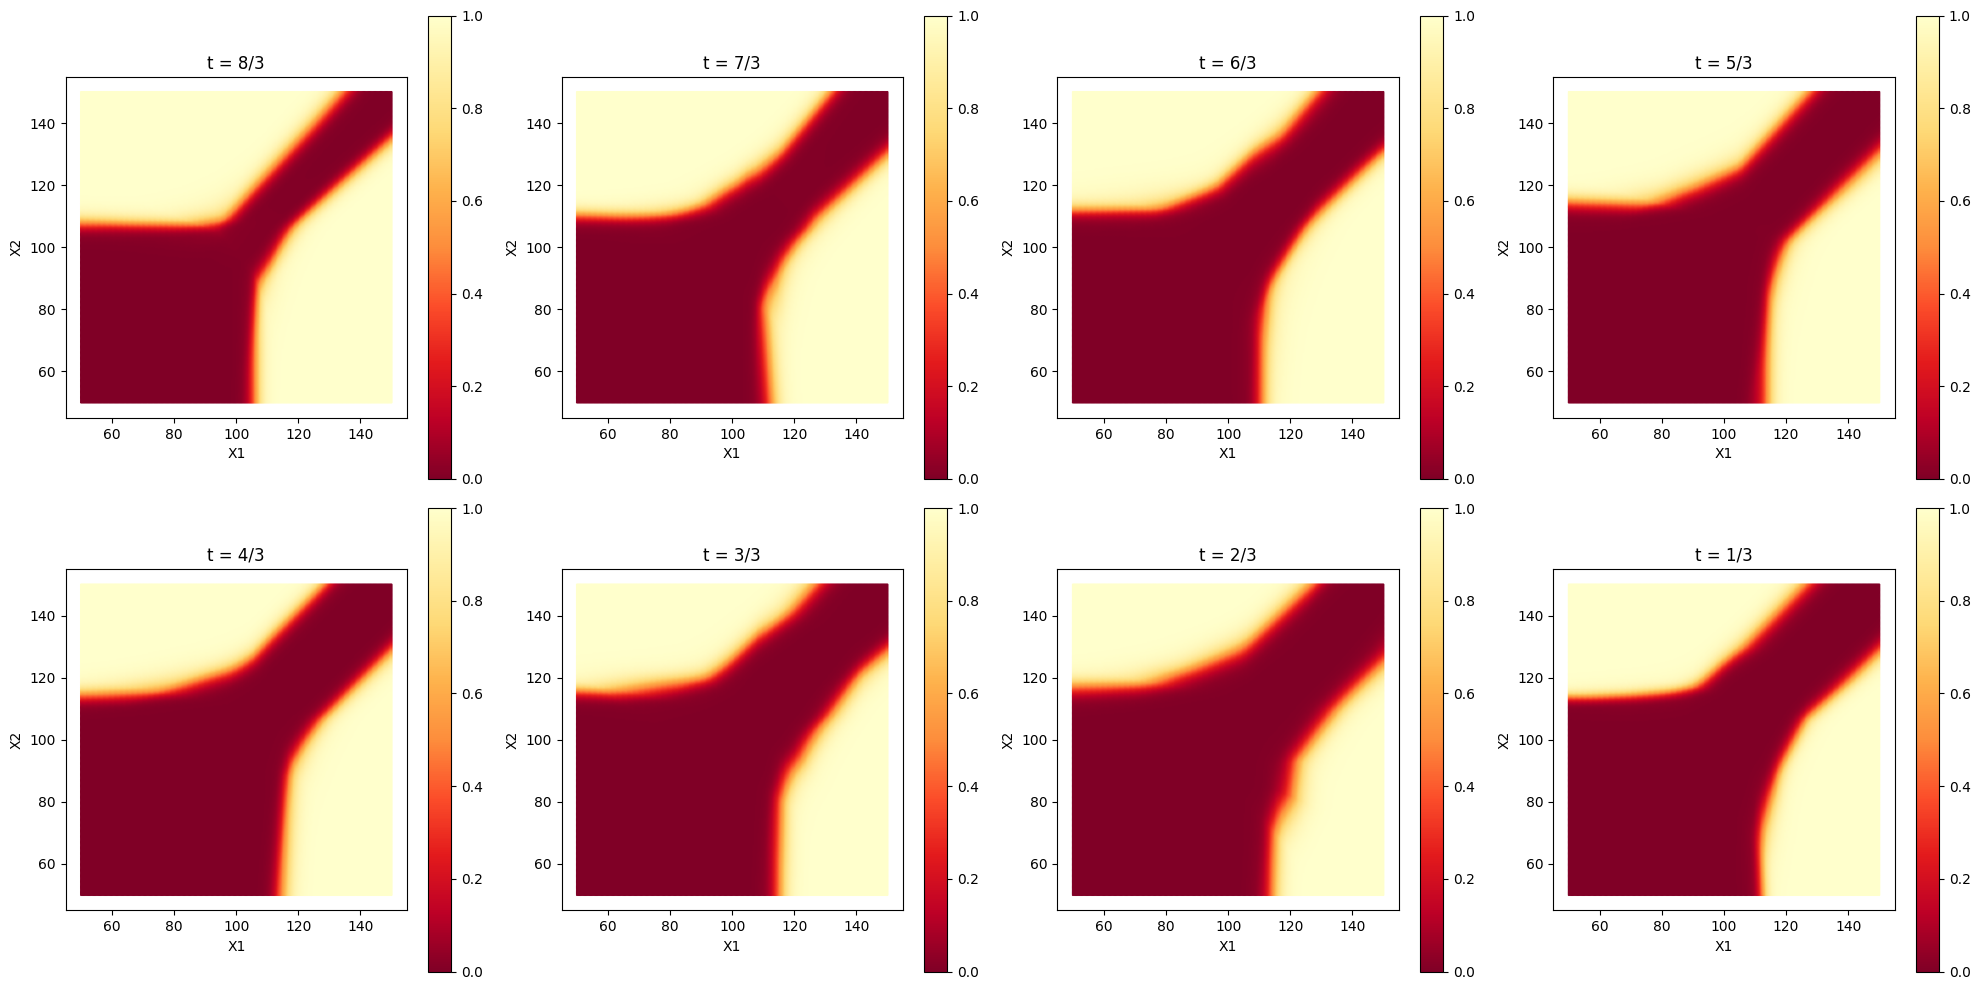

In [25]:
### GENERATE TABLE WITH ALL PLOTS

x_train = gen_grid(256,50,150)
# Define color mapping
color_map = "YlOrRd_r"

fig, axs = plt.subplots(2, 4, figsize=(20, 10),dpi=100.0)
for i in range(8):
    classi = classifiers[8 - i].cpu()  # Access classifiers in reverse order
    classi.eval()
    predictor_test = (classi.forward(x_train)).detach().numpy()
    ax = axs[i//4, i%4]  # Subplot positioning in 2 by 4 grid
    scatter = ax.scatter(x_train[:, 0], x_train[:, 1], c=predictor_test, cmap=color_map, s=0.5)
    ax.set_title('t = {}/3'.format(8 - i))
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax)
    ax.set_aspect('equal', 'box')
# Adjust layout
plt.tight_layout()
plt.savefig('drive/MyDrive/TFG/all_plots.png')
# Show the plots
plt.show()